## Промежуточный проект karpov_courses. 

Выполняется в рамках прохождения курсов по специальности Аналитик Данных

Текст Задания:

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров.

In [148]:
# Импорт библиотек
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
import datetime
from datetime import date
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(font_scale = 1.5, style = 'whitegrid', rc = {'figure.figsize' : (20,8)})

## Предварительный анализ и предобработка данных

### Датасет customers содержит данные о пользователях.

Описание полей:<br>
<strong>customer_id</strong> —  позаказный идентификатор пользователя<br>
<strong>customer_unique_id</strong> —  уникальный идентификатор пользователя (аналог номера паспорта)<br>
<strong>customer_zip_code_prefix</strong> —  почтовый индекс пользователя<br>
<strong>customer_city</strong> —  город доставки пользователя<br>
<strong>customer_state</strong> —  штат доставки пользователя

In [149]:
# Скачаем датасет customers
url_customers = 'https://disk.yandex.ru/d/d71Av5E6ut1j_Q'
customers = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{url_customers}')
print(customers.shape)
customers.head(2)

(99441, 5)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


### Датасет orders содержит данные о заказах

<strong>order_id</strong> —  уникальный идентификатор заказа (номер чека)<br>
<strong>customer_id</strong> —  позаказный идентификатор пользователя<br>
<strong>order_status</strong> —  статус заказа<br>
<strong>order_purchase_timestamp</strong> —  время создания заказа<br>
<strong>order_approved_at</strong> —  время подтверждения оплаты заказа<br>
<strong>order_delivered_carrier_date</strong> —  время передачи заказа в логистическую службу<br>
<strong>order_delivered_customer_date</strong> —  время доставки заказа<br>
<strong>order_estimated_delivery_date</strong> —  обещанная дата доставки<br>

In [150]:
# Скачаем датасет orders
url_orders = 'https://disk.yandex.ru/d/cnqnBzoE1nFdaQ'
orders = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{url_orders}')
print(orders.shape)
orders.head(2)

(99441, 8)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


### Датасет items содержит данные о товарах, входящих в заказы

<strong>order_id</strong> —  уникальный идентификатор заказа (номер чека)<br>
<strong>order_item_id</strong> —  идентификатор товара внутри одного заказа<br>
<strong>product_id</strong> —  ид товара (аналог штрихкода)<br>
<strong>seller_id</strong> — ид производителя товара<br>
<strong>shipping_limit_date</strong> —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике<br>
<strong>price</strong> —  цена за единицу товара<br>
<strong>freight_value</strong> —  вес товара

In [151]:
# Скачаем датасет items
url_items = 'https://disk.yandex.ru/d/scehJqZxnvHSIw'
items = pd.read_csv(f'https://getfile.dokpub.com/yandex/get/{url_items}')
print(items.shape)
items.head(2)

(112650, 7)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


### Подготовка объединенного датафрейма

In [119]:
# Объединяем таблицы с данными в единый датафрейм
e_comm_data = orders.merge(customers, how='left', on='customer_id').merge(items, how='left', on='order_id')

# Заполняем "нулями" все ячейки, где содержатся "Na"
e_comm_data = e_comm_data.fillna(0)

# Переводим все необходимые столбцы в формат даты
e_comm_data[['order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date', 'order_approved_at' ]] \
            = e_comm_data[['order_delivered_carrier_date','order_delivered_customer_date', 'order_estimated_delivery_date','shipping_limit_date', 'order_approved_at']] \
            .apply(pd.to_datetime, format='%Y-%m-%d')

# Переведем все необходимые столбцы в тип str (сейчас стоит тип object)
e_comm_data[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',\
             'customer_unique_id', 'customer_city', 'customer_state', 'product_id', 'seller_id']]\
            = e_comm_data[['order_id', 'customer_id', 'order_status','order_purchase_timestamp',\
                           'customer_unique_id', 'customer_city', 'customer_state', 'product_id', 'seller_id']].astype(str)

print(e_comm_data.shape)
e_comm_data.head(2)


(113425, 18)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76


### Сформулируем, что должно считаться покупкой

Факт покупки (для заданий 1, 3-6) будет фиксироваться при одновременном выполнении следующих условий:
1. Оплата подтверждена (столбец 'order_approved_at' содержит данные);
2. Товар доставлен пользователю (столбец 'orders_status'='delivered')

In [120]:
# Подготавливаем вспомогательный датафрейм (для заданий 1, 3-6):

# Шаг 1 - фильтруем датафрейм по критериям 1 и 2 выше, также убираем данные.
# Шаг 2 - убираем аномалии/неполные данные - строки, где нет даты доставки, где price, freight_value равны 0

e_comm_data_purchased = e_comm_data \
                            .query('order_approved_at!="1970-01-01"')\
                            .query('order_status=="delivered"')\
                            .query('order_delivered_customer_date!="1970-01-01"')\
                            .query('price!=0')\
                            .query('freight_value!=0')


## Задание 1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [121]:
# Шаг 1 - рассчитываем количество покупок, приходящихся на каждого пользователя
# Шаг 2 - оставляем в датафрейме только те строки, где количество покупок равно 1
# Шаг 3 - рассчитываем количество строк в датафрейме (=искомый ответ)

users_bought_once = e_comm_data_purchased \
                            .groupby('customer_unique_id', as_index=False).order_id.nunique() \
                            .query('order_id==1') \
                            .count()
print("Ответ: {}".format(users_bought_once.customer_unique_id))


Ответ: 90211


## Задание 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [122]:
# Отберем недоставленные заказы
e_2 = e_comm_data.query('order_delivered_customer_date=="1970-01-01"')\
        [['order_id', 'order_status', 'order_estimated_delivery_date']]
        
# Исходя из имеющихся статусов, заказы не доставляются по двум причинам:
#заказ отменен или товара нет в наличии. Предполагаю, что заказы с остальными статусами будут рано или поздно доставлены
#Оставим заказы со статусами отменен или недоступен
e_2 = e_2[(e_2.order_status=='unavailable') | (e_2.order_status=='canceled')]

# Подсчитаем количество недоставленных заказов по месяцам от обещанной даты доставки
e_2['month'] = e_2['order_estimated_delivery_date'].dt.to_period('M')
e_2 = e_2.groupby(['month', 'order_status'], as_index=False).agg({'order_id':'nunique'})
e_2 = e_2.rename(columns={'order_id':'orders_not_delivered'})

# Подсчитаем среднее количество недоставленных заказов в месяц с детализацией по причинам
e_2 = e_2.groupby('order_status', as_index=False).agg({'orders_not_delivered':'mean'})
e_2['orders_not_delivered'] = e_2['orders_not_delivered'].round(0)

print("Ответ:")
e_2

Ответ:


,order_status,orders_not_delivered
0,canceled,24.0
1,unavailable,29.0


## Задание 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [123]:
# Анализировать покупки будем по датам оплаты,так как факт доставки не зависит от поведения пользователей.


# Добавим в датафрейм колонку с названием дней недели
e_comm_data_purchased['weekday'] = e_comm_data_purchased['order_approved_at'].dt.day_name()

# Шаг 1 - подсчитываем количество заказов, сгруппировав данны по продуктам и дням недели
# Шаг 2 - отбираем только те строки, где значение 'product_id' не равно 0, то есть убираем те продукты,
#по которым у нас нет данных (=данные не занесены в справочник)

e_3 = e_comm_data_purchased \
            .groupby(['product_id', 'weekday'], as_index=False).agg({'order_approved_at':'count'}) \
            .query('product_id!=0')

# Сделаем сводную таблицу, где количество покупок будет отражено по дням в столбцах
e_3 = e_3.pivot(index='product_id', columns='weekday', values='order_approved_at').fillna(0).reset_index()

# Сформируем сводную таблицу по порядку по дням недели
e_3 = e_3[['product_id','Monday','Tuesday','Wednesday','Thursday','Friday', 'Saturday', 'Sunday']]

# Добавим столбец с итоговым количеством покупок по товарам
e_3['total_purchases'] = e_3.loc[:, 'Monday':'Sunday'].sum(axis=1)

# Оставим только те товары, количество покупок которых больше 20, так как нет смысла определять день недели,
#в который товар покупался чаще всего при малом объеме покупок этого товара
e_3 = e_3.query('total_purchases>20')

# Добавим колонку 'max_purchases', где будет отражено наибольшее количество покупок товара в день
e_3['max_purchases_per_day'] = e_3.loc[:, 'Monday':'Sunday'].max(axis=1)

# Добавим колонку 'days', где выведем дни, в которые совершалось наибольшее количество покупок среди недели
e_3['days'] = e_3.apply(lambda row: row[row == row['max_purchases_per_day']].index.tolist(), axis=1)

# Добавим колонку искомую колонку 'most_often_bought_days', где выведем дни,
#в которые совершалось наибольшее количество покупок среди недели
#("вычистим" из колонки 'days' 'max_purchases_per_day', который попал в список на предыдущем шаге)
e_3['most_often_bought_days'] = e_3['days'].apply(lambda x: x[:-1])

# Оставим в датафрейме только необходимые столбцы
e_3 = e_3[['product_id', 'total_purchases', 'max_purchases_per_day', 'most_often_bought_days']]\
        .sort_values(by='total_purchases', ascending=False)

print("Ответ:")
e_3.head()

Ответ:


weekday,product_id,total_purchases,max_purchases_per_day,most_often_bought_days
19287,99a4788cb24856965c36a24e339b6058,477.0,78.0,[Tuesday]
8427,422879e10f46682990de24d770e7f83d,428.0,81.0,[Friday]
21613,aca2eb7d00ea1a7b8ebd4e68314663af,423.0,86.0,[Friday]
7204,389d119b48cf3043d311335e499d9c6b,390.0,75.0,[Tuesday]
6924,368c6c730842d78016ad823897a372db,388.0,80.0,[Thursday]


## Задание 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

In [124]:
e_4 = e_comm_data_purchased

# Добавляем столбцы с датой начала месяца от даты подтверждения заказа
e_4['StartOfMonth'] = (e_4['order_approved_at'].dt.floor('d') + 
                           pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1))

e_4['StartOfMonth'].dt.date

# Сгруппируем данные по месяцам и покупателям и подсчитаем количество покупок
e_4 = e_4.groupby(['customer_unique_id', 'StartOfMonth'], as_index=False).agg({'order_id':'nunique'})

# Добавим столбец с датой окончания месяца от даты подтверждения заказа, затем добавим столбец с количеством недель в месяце
e_4['EndOfMonth'] = pd.to_datetime(e_4['StartOfMonth'], format="%Y%m") + MonthEnd(1)
e_4['number_of_weeks'] = ((e_4['EndOfMonth'] - e_4['StartOfMonth']).dt.days + 1)/7

# Добавим столбец со средним количеством покупок в неделю
e_4['average_purchases_per_week'] = round(e_4['order_id'] / e_4['number_of_weeks'],2)

# Добавим столбец с месяцем покупки в формате "год_месяц", а затем сгруппируем данные в сводную аблицу
e_4['year_month'] = e_4['StartOfMonth'].dt.to_period('M')
e_4 = e_4.pivot(index='customer_unique_id', columns='year_month', values='average_purchases_per_week').fillna(0)

# Добавим столбец с максимальным средним количеством покупок в неделю
e_4['max_average_purchases_per_week'] =e_4.loc[:, "2016-09":].max(axis=1)

# Отфильтруем финальный датасет по максимальному среднему количество покупок в неделю
e_4 = e_4.reset_index().sort_values(by='max_average_purchases_per_week', ascending=False)

print("Ответ:")
e_4.head()

Ответ:


year_month,customer_unique_id,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,max_average_purchases_per_week
6941,12f5d6e1cbf93dafd9dcc19095df0b3d,0.0,0.0,0.0,1.35,0.0,0.0,0.00,0.0,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.35
58981,a239b8e2fbce33780f1f1912e2ee5275,0.0,0.0,0.0,0.00,1.0,0.0,0.00,0.0,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.00
22697,3e43e6105506432c953e165fb2acf44c,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,...,0.68,0.23,1.0,0.00,0.0,0.0,0.0,0.0,0.0,1.00
65827,b4e4f24de1e8725b74e4a1f4975116ed,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,...,0.00,0.00,1.0,0.23,0.0,0.0,0.0,0.0,0.0,1.00
13740,25a560b9a6006157838aab1bdbd68624,0.0,0.0,0.0,0.00,0.0,0.0,0.93,0.0,0.0,...,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.93


## Задание 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц

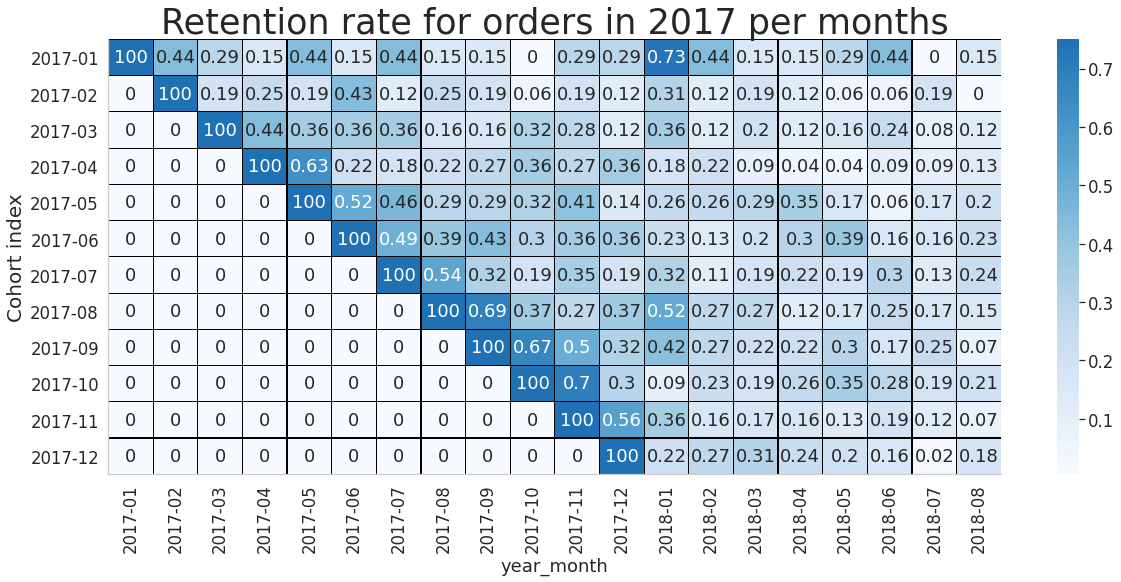

In [125]:
#5 Используя pandas, проведи когортный анализ пользователей.
#В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц

# Для целей анализа выберем 2017 год, так это единственный "полный" год в предоставленных данных

e_5 = e_comm_data_purchased

# Добавим столбец с месяцем покупки
e_5['year_month'] = e_5['order_approved_at'].dt.to_period('M')

# Сформируем исходный датафрейм для работы
e_5 = e_5[['customer_unique_id', 'year_month', 'order_id']]

# Создадим вспомогательный датафрейм, в котором определим месяц первой покупки для каждого покупателя
e_5_first_purchase = e_5.groupby('customer_unique_id', as_index=False).agg({'year_month':'min'})
e_5_first_purchase = e_5_first_purchase.rename(columns={'year_month':'cohort'})

# Добавим в исходный датафрейм месяц первой покупки для каждого покупателя, оставим только когорты за 2017 год
e_5 = e_5.merge(e_5_first_purchase, how='inner', on='customer_unique_id')
e_5 = e_5.query('cohort>="01-01-2017"').query('cohort<"01-01-2018"')

# Подсчитаем количество уникальных пользователей по когортам в разрезе месяцев
e_5 = e_5.groupby(['year_month', 'cohort'], as_index=False).agg({'customer_unique_id':'nunique'})\
                .rename(columns={'customer_unique_id':'quantity'})

# Подсчитаем размер каждой когорты
cohort_size = e_5.query('cohort==year_month')[['cohort', 'quantity']]\
            .rename(columns={'quantity':'cohort_size'})

# Добавим датафрейм размер когорты и подсчитаем retention для каждой когорты
e_5 = e_5.merge(cohort_size, how='inner', on='cohort')
e_5['retention'] = round((e_5['quantity'] / e_5['cohort_size']) *100, 2)

# Сформируем сводную таблицу с данными по retention rate
e_5_retention = e_5.pivot(index='cohort', columns='year_month', values='retention').fillna(0)
           
# Визуализируем retention rate
cx = sns.heatmap(e_5_retention,
                 fmt ='.3g',
                 annot=True,
                 linewidths=.15,
                 vmax=.75, 
                 vmin=.005,
                 center=0.50,
                 cmap= 'Blues',
                 linecolor='black'
                )
cx.set_title('Retention rate for orders in 2017 per months', fontsize= 35)
cx.set_ylabel('Cohort index',fontsize= 20)
sns.despine()


In [126]:
# Выявим когорту с самым высоким retention на 3й месяц

# Добавим столбец 'date_cohort_diff', оставим данные, где 'date_cohort_diff' 3 (3 месяц после первой покупки)
e_5['date_cohort_diff'] = e_5['year_month'].astype(int) - e_5['cohort'].astype(int)
e_5 = e_5[(e_5.date_cohort_diff==3)]
# Найдем когорту с самым высоким retention на 3й месяц
max_retention = e_5[(e_5.date_cohort_diff==3)].retention.max()
e_5.query('retention==@max_retention')['cohort']

90    2017-06
Name: cohort, dtype: period[M]

## Задание 6. RFM-сегментация пользователей

### Подход к сегментации

Прежде чем определиться с подходом к кластеризации, еще раз посмотрим на особенность исходных данных.

In [127]:
e_comm_data_purchased\
                    .groupby('customer_unique_id', as_index=False).agg({'order_id':'nunique'})\
                    .groupby('order_id', as_index=False).agg({'customer_unique_id':'count'})\
                    .rename(columns={'order_id':'Number_of_purchases', 'customer_unique_id':'Number_of_customers'})

,Number_of_purchases,Number_of_customers
0,1,90211
1,2,2570
2,3,179
3,4,28
4,5,9
5,6,5
6,7,3
7,9,1
8,15,1


Как видно из таблицы выше, бОльшая часть покупателей совершила покупку только 1 раз, подавляющее большинство остальных - 2 раза. Исходя из этого, предлагаем следующий подход к кластеризации:
1. Frequency - частота покупок. Для целей скоринга будем присваивать 1 для Frequency=1, 2 для Frequency=3 и 3 для Frequency>2.
2. Recency - время от последней покупки пользователя до текущей даты. Для целей скоринга будем присваивать 1 для Recency>полугода и 2 для Recency<полугода.
3. Monetary - сумма покупок за всё время. Для целей скоринга будем присваивать 1 для Monetary=<75% перцентиля и 2 для Monetary>75% перцентиля (покупатели, совершающие "дорогие покупки").

Учитывая, что большинство покупателей совершает покупку только 1 раз и крайние низкие показатели retention rate, делить полкупателей по критериям Recency и Monetary более чем на два кластера нецелесообразно.

In [152]:
# 6. RFM-сегментация пользователей. Часть 1-я - Подготовка исходных данных

e_6 = e_comm_data_purchased

# Создадим вспомогательный датафрейм, где найдем дату последней покупки для каждого пользователя, а затем
#количество дней (Recency) от последней покупки пользователя до текущей даты. В качестве текущей даты
#"назначим" последнюю дату анализируемого датасета (20.08.2018).

e_6_last_purchase = e_6.groupby('customer_unique_id', as_index=False).agg({'order_approved_at':'max'})
current_date = e_6_last_purchase['order_approved_at'].max()
e_6_last_purchase['Recency'] = (current_date.normalize()-e_6_last_purchase['order_approved_at']).dt.days+1
e_6_last_purchase = e_6_last_purchase[['customer_unique_id', 'Recency']]

# Создадим вспомогательный датафрейм, где найдем суммарное количество покупок у пользователя за всё время (Frequency)
e_6_number_of_purchases = e_6\
                            .groupby('customer_unique_id', as_index=False).agg({'order_id':'nunique'})\
                            .rename(columns={'order_id':'Frequency'})

# Создадим вспомогательный датафрейм, где найдем  сумму покупок за всё время для каждого пользователя (Monetary)
e_6_revenue_per_customer = e_6\
                            .groupby('customer_unique_id', as_index=False).agg({'price':'sum'})\
                            .rename(columns={'price':'Monetary'})

# Создадим объединенный датафрейм с  данными по Recency, Frequency, Monetary
e_6_RFM = e_6_last_purchase\
        .merge(e_6_number_of_purchases, how='inner', on='customer_unique_id')\
        .merge(e_6_revenue_per_customer, how='inner', on='customer_unique_id')



In [153]:
# 6. RFM-сегментация пользователей. Часть 2-я - Скоринг

# Проскорим покупателей по Recency, разбив период на два промежутка - более полугода (180 дней)  от текущей даты
#и не более полугода (180 дней) от текущей даты.
e_6_RFM['R'] = e_6_RFM['Recency'].apply(lambda x: 1 if x>180 else 2)

# Проскорим покупателей по Frequency, присвоим 1 для Frequency=1, 2 для Frequency=3 и 3 для Frequency>2
e_6_RFM['F'] = e_6_RFM['Frequency'].apply(lambda x: 1 if x==1 else\
                                                                  (2 if x==2  else 3)    )

# Проскорим покупателей по Monetary. Для целей скоринга будем присваивать 1 для Monetary <=75% квантиля
#2 - для Monetary больше 75% квантиля
quanttile_75 = e_6_RFM['Monetary'].quantile(.75)
e_6_RFM['M'] = e_6_RFM['Monetary'].apply(lambda x: 1 if x<=quanttile_75 else 2)


# Подготовим описание для скоринг-баллов

Score = [1,2,3]
R = ["Не более 180 дней", "Более 180 дней", "-"]
F = ["1 покупка", "2 покупки", "более 2 покупок"]
M = ["Сумма покупок не более {} у.е.".format(quanttile_75),\
     "Сумма покупок более {} у.е.".format(quanttile_75),\
     "-"]

score_description = pd.DataFrame()
score_description = score_description.assign(Score = Score, R = R, F = F, M = M)
description = "R - время от последней покупки пользователя до текущей даты\n"+\
            "F - суммарное количество покупок у пользователя за всё время\n"+\
            "M - сумма покупок за всё время"

In [154]:
# 6. RFM-сегментация пользователей. Часть 3-я

e_6_RFM_output = e_6_RFM

# Добавим столбец с RFM-сегментом и RF-сегментом
e_6_RFM_output['RFM_segment'] = e_6_RFM_output['R'].astype(str)\
                            + e_6_RFM_output['F'].astype(str)\
                            + e_6_RFM_output['M'].astype(str)

# Сгруппируем данные по RFM-сегментам и рассчитаем количество покупателей
e_6_RFM_output = e_6_RFM_output.groupby('RFM_segment', as_index=False).agg({'customer_unique_id':'count'})\
                                .sort_values(by='customer_unique_id', ascending=False)

e_6_RFM_output = e_6_RFM_output.rename(columns={'customer_unique_id':'number_of_customers'})
# Выведем данные по RFM-сегментам
e_6_RFM_output.sort_values(by='number_of_customers', ascending=False)

,RFM_segment,number_of_customers
0,111,40746
6,211,27902
1,112,12684
7,212,8879
3,122,827
9,222,664
2,121,633
8,221,446
11,232,102
5,132,75


In [155]:
# 6. RFM-сегментация пользователей. Ответ - описание сегментов

print(description)
score_description

R - время от последней покупки пользователя до текущей даты
F - суммарное количество покупок у пользователя за всё время
M - сумма покупок за всё время


,Score,R,F,M
0,1,Не более 180 дней,1 покупка,Сумма покупок не более 154.9 у.е.
1,2,Более 180 дней,2 покупки,Сумма покупок более 154.9 у.е.
2,3,-,более 2 покупок,-


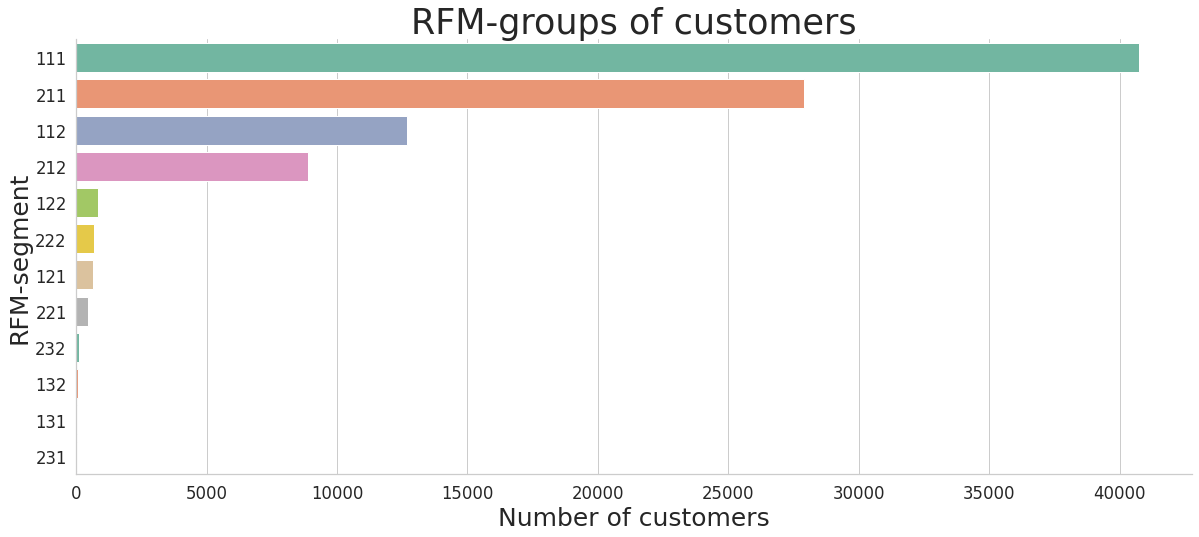

In [156]:
# 6. RFM-сегментация пользователей - визуализация

dx = sns.barplot(data = e_6_RFM_output, 
            x = 'number_of_customers', 
            y = 'RFM_segment',
            palette =  'Set2'
           )
dx.set_title('RFM-groups of customers', fontsize= 35)
dx.set_ylabel('RFM-segment',fontsize= 25)
dx.set_xlabel('Number of customers',fontsize= 25)
sns.despine()

#### 6. RFM-сегментация пользователей - вывод

Как и результаты предыдущих заданий, RFM-анализ показывает, что подавляющее большинство покупателей компании совершают не более одной покупки, поэтому нельзя составить "портрет постоянного покупателя компании". Несмотря на то,что второй по численности сегмент  - 211 (покупатели, которые совершили одну "недорогую" покупку в течение последних 180 дней), маловероятно, что данные покупатели сделают второй заказ, учитывая крайние низкие показатели retention компании (см. результаты задания 5). Мы не знаем специфику бизнеса компании, однако, исходя из проанализированных данных видим, что пользователи могут совершать повторные покупки. Рекомендация - выяснить причину низкого удержания клиентов (например, получить обратную связь о качестве товаров/сервиса от покупателей, совершивших покупку недавно (сегменты с баллом 2 по признаку Recency)) и поработать над увеличением retention (например, запустить программу лояльности).